In [14]:
#| code-summary: code -- load dependencies and data and select parameters
#| echo: false
#| output: false

from compmemlearn.fitting import generate_objective_function, model_weights
from compmemlearn.datasets import events_metadata, generate_trial_mask, simulate_df_from_events
from sentence_transformers import SentenceTransformer, util
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import os

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

figure_caption = """Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model."""

section_tag = "Murdock1962"

data_path = "C:/Users/gunnj/compmemlearn/data/narrative/psifr_sbs.csv" 
results_path = "C:/Users/gunnj/compmemlearn/reports/subjectwise_model_evaluation/results/"
figures_path = "figures/"
trial_query = "subject > -1"

model_paths = [
    "compmemlearn.models.Semantic_CMR",
    "compmemlearn.models.Semantic_CMR",
    "compmemlearn.models.Semantic_CMR",
]

model_names = ["Base_Semantic_CMR", "Semantic_CMR", "Forced_Semantic_CMR"]

free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
        [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
        "semantic_scale"
    ],
            [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
        "semantic_scale"
    ],
]
bounds = [
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
        [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
        [.15, 10],
    ],
]
fixed_parameters = [
    {'semantic_scale': 0.0},
    {},
    {}
]

language_model_string = 'average_word_embeddings_glove.6B.300d'

analysis_paths = ['compmemlearn.analyses.plot_spc', 'compmemlearn.analyses.plot_crp', 'compmemlearn.analyses.plot_pfr', 'compmemlearn.analyses.plot_sem_crp']
analysis_names = ['spc', 'crp', 'pfr', 'semcrp']

experiment_count = 100

In [15]:
#| echo: false
#| output: false

if 'Howard' in section_tag or ('Lohnas' in section_tag and '1' not in section_tag):
    analysis_paths = ['compmemlearn.analyses.plot_flex_spc', 'compmemlearn.analyses.plot_flex_crp', 'compmemlearn.analyses.plot_flex_pfr', 'compmemlearn.analyses.plot_rpl']
    analysis_names = ['spc', 'crp', 'pfr', 'rpl']


print(os.path.abspath(data_path))

C:\Users\gunnj\compmemlearn\data\narrative\psifr_sbs.csv


In [3]:
#| code-summary: code -- test that specified parameters are valid
#| echo: false
#| output: false

events = pd.read_csv(data_path)

trials, list_lengths, presentations, item_strings = events_metadata(events)
trial_mask = generate_trial_mask(events, trial_query)

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1)
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# import analyses from specified source
analyses = []
for i in range(len(analysis_paths)):
    module_name, analysis_name = analysis_paths[i].rsplit('.',1)
    module = importlib.import_module(module_name)
    analyses.append(getattr(module, analysis_name))

# load language model and relevant item strings
if language_model_string is not None:
    language_model = SentenceTransformer(language_model_string)
    # item_strings = events.pivot_table(
    #         index=['subject', 'list'], columns='item', values='item_string', aggfunc='first', dropna=False).to_numpy()
else:
    language_model = None
    # item_strings = None

# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    extra_mask = generate_trial_mask(events, f'subject == {pd.unique(events.subject)[0]}')
    subject_specific_trial_mask = [np.logical_and(extra_mask[i], trial_mask[i]) for i in range(len(trial_mask))]

    cost_function = generate_objective_function(
        [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
        [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
        list_lengths,
        init_model,
        fixed_parameters[model_index],
        free_parameters[model_index],
        language_model,
        [item_strings[i][subject_specific_trial_mask[i]] for i in range(len(trials))] if item_strings else item_strings
    )
    print(cost_function)
    
    for boundary_index in range(2):
        x = np.array([each[boundary_index] for each in bounds[model_index]])
        assert(len(x) == len(free_parameters[model_index])) 

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        if language_model is None:
            model = init_model(20, 20, parameters)
        else:
            embeddings = language_model.encode(item_strings[0][0])
            cosine_scores = util.pytorch_cos_sim(embeddings, embeddings).numpy() + 1
            np.fill_diagonal(cosine_scores, 0)
            model = init_model(cosine_scores, len(item_strings[0][0]), parameters)

        model.experience(model.items)
        model.free_recall()

        print(cost_function(x))

print('dependencies and parameters validated')

<function semantic_objective_function.<locals>.objective_function at 0x0000022FC0731E50>
1713.119203377894
4420.963742552656
<function semantic_objective_function.<locals>.objective_function at 0x0000022FC4001430>
1713.119203377894
4420.963742552656
<function semantic_objective_function.<locals>.objective_function at 0x0000022FC0FE3310>
1713.119203377894
4420.963742552656
dependencies and parameters validated


In [4]:
#| code-summary: code -- 1) fit each model class participant-by-participant
#| echo: false
#| output: false

for model_index, model_class in enumerate(models):

    # load individual fits for this model and section tag from csv if they exist
    if os.path.isfile(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])):
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]))
        print('individual fits for {} with tag {} already exist'.format(model_names[model_index], section_tag))

    # otherwise, fit each participant individually
    else:
        model_individual_fits = []

        @njit(fastmath=True, nogil=True)
        def init_model(item_count, presentation_count, parameters):
            return model_class(item_count, presentation_count, parameters)

        for subject in pd.unique(events.subject):
            print(f'{model_names[model_index]}, Subject {subject}')

            extra_mask = generate_trial_mask(events, f'subject == {pd.unique(events.subject)[0]}')
            subject_specific_trial_mask = [
                np.logical_and(extra_mask[i], trial_mask[i]) for i in range(len(trial_mask))]
            
            try:
                # cost function to be minimized
                # ours scales inversely with the probability that the data could have been
                # generated using the specified parameters and our model
                cost_function = generate_objective_function(
                    [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
                    [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
                    list_lengths,
                    init_model,
                    fixed_parameters[model_index],
                    free_parameters[model_index],
                    language_model,
                    [item_strings[i][subject_specific_trial_mask[i]] for i in range(len(trials))] if item_strings else item_strings
                )
            except ValueError:
                continue

            fit_result =  differential_evolution(cost_function, bounds[model_index], disp=False)

            fitted_parameters = {
                'subject': subject, 
                'trial_count': np.sum(
                    [np.sum(subject_specific_trial_mask[i]) for i in range(len(subject_specific_trial_mask))]), 
                'likelihood': fit_result.fun, 'model': model_names[model_index]
                }
            for i in range(len(fit_result.x)):
                fitted_parameters[free_parameters[model_index][i]] = fit_result.x[i]
            for key in fixed_parameters[model_index]:
                fitted_parameters[key] = fixed_parameters[model_index][key]

            model_individual_fits.append(
                pd.DataFrame.from_dict(fitted_parameters, orient='index').T)
            print(model_individual_fits[-1]['likelihood'][0])

        model_individual_fits = pd.concat(model_individual_fits, ignore_index=True)
        model_individual_fits.to_csv(
            results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]), index=False)

individual fits for Base_Semantic_CMR with tag Murdock1962 already exist
individual fits for Semantic_CMR with tag Murdock1962 already exist
Forced_Semantic_CMR, Subject 0
634.6114789658451
Forced_Semantic_CMR, Subject 1
636.3051118583156
Forced_Semantic_CMR, Subject 2
632.5601730368917
Forced_Semantic_CMR, Subject 3
632.981661940002
Forced_Semantic_CMR, Subject 4
635.032343778667
Forced_Semantic_CMR, Subject 5
636.2357035623722
Forced_Semantic_CMR, Subject 6
633.7316508408121
Forced_Semantic_CMR, Subject 7
634.7664951138152
Forced_Semantic_CMR, Subject 8
641.5244096480443
Forced_Semantic_CMR, Subject 9
634.5806140526978
Forced_Semantic_CMR, Subject 10
634.4945828267723
Forced_Semantic_CMR, Subject 11
633.945771170768
Forced_Semantic_CMR, Subject 12
634.1326364321266
Forced_Semantic_CMR, Subject 13
631.9655127169856
Forced_Semantic_CMR, Subject 14
629.6541911136408
Forced_Semantic_CMR, Subject 15
630.8188231983744
Forced_Semantic_CMR, Subject 16
633.2945316685583
Forced_Semantic_CMR, S

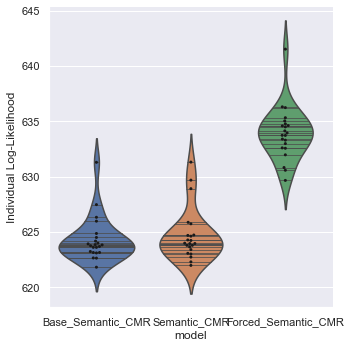

In [5]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects
#| echo: false

plt.style.use('default')
sns.set(style="darkgrid")

# build individual fits df concatenating results from each model
individual_fits = []
for model_index, model_class in enumerate(models):
    individual_fits.append(
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])))
individual_fits = pd.concat(individual_fits, ignore_index=True)

# plot distribution of log-likelihoods across individual subjects
g = sns.catplot(x='model', y='likelihood', data=individual_fits, kind='violin', inner='stick')
sns.swarmplot(x="model", y="likelihood", data=individual_fits, color="k", size=3, ax=g.ax)
g.ax.set_ylabel('Individual Log-Likelihood');
plt.savefig(figures_path + 'individual_{}.pdf'.format(section_tag), bbox_inches="tight")

In [6]:
#| echo: false
#| output: false

individual_fits

,subject,trial_count,likelihood,model,encoding_drift_rate,start_drift_rate,recall_drift_rate,shared_support,item_support,learning_rate,primacy_scale,primacy_decay,stop_probability_scale,stop_probability_growth,choice_sensitivity,delay_drift_rate,semantic_scale
0,0,18,626.318635,Base_Semantic_CMR,0.580442,0.993322,0.932670,0.052706,0.315996,0.145737,0.565763,30.227037,0.008353,0.148356,3.290905,0.241798,0.000000
1,1,18,623.095101,Base_Semantic_CMR,0.488582,0.976595,0.921785,0.237448,0.208412,0.284514,0.124373,23.494288,0.008042,0.146459,8.630969,0.592977,0.000000
2,2,18,625.968879,Base_Semantic_CMR,0.505770,0.930060,0.968210,0.009271,0.209431,0.315197,1.078532,1.956152,0.008837,0.146049,3.737432,0.799406,0.000000
3,3,18,623.847300,Base_Semantic_CMR,0.469114,0.957344,0.914844,0.177274,0.437517,0.292645,0.362371,41.386869,0.005239,0.163291,8.609834,0.666633,0.000000
4,4,18,623.983926,Base_Semantic_CMR,0.428421,0.944685,0.943128,0.099723,0.040258,0.356771,0.511566,33.323845,0.004001,0.184006,7.523495,0.576720,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,17,18,632.594807,Forced_Semantic_CMR,0.497112,0.949138,0.904757,0.050427,0.526341,0.189917,0.155088,20.391642,0.005149,0.175724,8.168268,0.004108,0.152191
62,18,18,630.572543,Forced_Semantic_CMR,0.511357,0.992992,0.956519,0.836146,0.408791,0.285274,85.400677,0.021561,0.006938,0.154408,4.065401,0.232701,0.677580
63,19,18,635.320267,Forced_Semantic_CMR,0.523300,0.928524,0.976303,0.093430,0.267957,0.371530,0.281209,3.296062,0.009637,0.151421,8.519870,0.300166,0.156265
64,20,18,633.720589,Forced_Semantic_CMR,0.522567,0.999284,0.915012,0.050873,0.573734,0.211200,0.107103,86.669625,0.010803,0.130963,7.750949,0.797037,0.162640


In [7]:
#| code-summary: display markdown rendering of summary table
#| echo: false
#| output: asis

summary_table = pd.DataFrame(group.describe().rename(columns={'likelihood':name}).squeeze()
            for name, group in individual_fits[['model', 'likelihood']].groupby('model')).T.to_markdown()

print("""::: {{#fig-{section_tag}fits layout-nrow=2 layout-valign="center"}}

![]({figures_path}individual_{section_tag}.pdf)

{summary_table}

{individual_fits_caption}
:::""".format(section_tag=section_tag, summary_table=summary_table, individual_fits_caption=figure_caption, figures_path=figures_path))

::: {#fig-Murdock1962fits layout-nrow=2 layout-valign="center"}

![](figures/individual_Murdock1962.pdf)

|       |   Base_Semantic_CMR |   Forced_Semantic_CMR |   Semantic_CMR |
|:------|--------------------:|----------------------:|---------------:|
| count |            22       |              22       |       22       |
| mean  |           624.291   |             633.92    |      624.705   |
| std   |             2.01804 |               2.41185 |        2.37007 |
| min   |           621.805   |             629.654   |      621.97    |
| 25%   |           623.158   |             632.692   |      623.457   |
| 50%   |           623.785   |             633.839   |      623.961   |
| 75%   |           624.413   |             634.728   |      624.708   |
| max   |           631.289   |             641.524   |      631.31    |

Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model.
:::


In [8]:
#| code-summary: perform t-tests on individual-level fits
#| output: asis
#| echo: false
 
from scipy.stats import ttest_rel
import itertools

for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='two-sided'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='less'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='greater'))
    print()

('Base_Semantic_CMR', 'Semantic_CMR')
Ttest_relResult(statistic=-0.6957155302149463, pvalue=0.49423504115290484)
Ttest_relResult(statistic=-0.6957155302149463, pvalue=0.24711752057645242)
Ttest_relResult(statistic=-0.6957155302149463, pvalue=0.7528824794235476)

('Base_Semantic_CMR', 'Forced_Semantic_CMR')
Ttest_relResult(statistic=-13.372953991825524, pvalue=9.634077532769679e-12)
Ttest_relResult(statistic=-13.372953991825524, pvalue=4.8170387663848395e-12)
Ttest_relResult(statistic=-13.372953991825524, pvalue=0.999999999995183)

('Semantic_CMR', 'Forced_Semantic_CMR')
Ttest_relResult(statistic=-13.485375663024032, pvalue=8.223954621363817e-12)
Ttest_relResult(statistic=-13.485375663024032, pvalue=4.111977310681908e-12)
Ttest_relResult(statistic=-13.485375663024032, pvalue=0.999999999995888)



In [9]:
#| echo: false
#| output: asis

for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(np.mean(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.mean(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print(np.sum(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.sum(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print()

('Base_Semantic_CMR', 'Semantic_CMR')
0.5454545454545454 0.45454545454545453
12 10

('Base_Semantic_CMR', 'Forced_Semantic_CMR')
1.0 0.0
22 0

('Semantic_CMR', 'Forced_Semantic_CMR')
1.0 0.0
22 0



In [10]:
#| echo: false
#| output: asis

aicw = {'Model': [], 'Subject': [], 'AICw': []}

total_nlns = np.zeros(len(models))
for subject_index, subject in enumerate(pd.unique(events.subject)):

    extra_mask = generate_trial_mask(events, f'subject == {pd.unique(events.subject)[0]}')
    subject_specific_trial_mask = [
        np.logical_and(extra_mask[i], trial_mask[i]) for i in range(len(trial_mask))]

    nlnLs = []
    for model_index, model_class in enumerate(models):
        nlnLs.append(
            individual_fits[individual_fits.model == model_names[model_index]].likelihood.values[subject_index])
    nlnLs = np.array(nlnLs)
    total_nlns += nlnLs
    
    weights = model_weights(nlnLs, len(free_parameters[model_index]), np.sum(
                    [np.sum(subject_specific_trial_mask[i]) for i in range(len(subject_specific_trial_mask))]))
    #print(weights)
    for model_index, model_class in enumerate(models):
        aicw['Model'].append(model_names[model_index])
        aicw['Subject'].append(subject)
        aicw['AICw'].append(weights[model_index])

aicw = pd.DataFrame(data=aicw)
total_aicw = model_weights(total_nlns, len(free_parameters[model_index]),np.sum(
                    [np.sum(trial_mask[i]) for i in range(len(trial_mask))]))
print(total_aicw)

[9.99887083e-01 1.12917023e-04 1.01590745e-92]


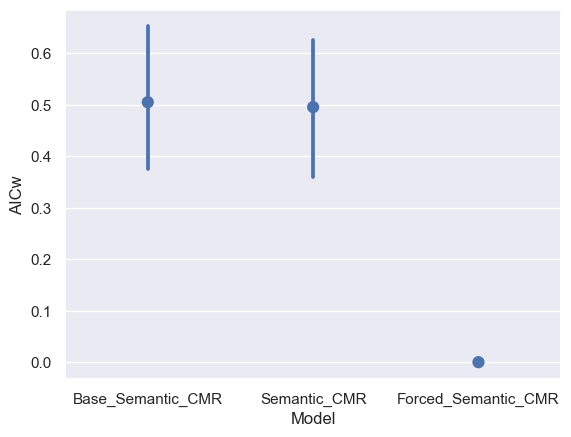

In [11]:
#| echo: false

import seaborn as sns
sns.set_theme(style="darkgrid")
x = sns.pointplot(x="Model", y="AICw", data=aicw, join=False)

plt.show()

In [12]:
#| echo: false
#| output: false
from compmemlearn.datasets import find_first

sim_df for Base_Semantic_CMR with tag Murdock1962 and list length 41 already exists


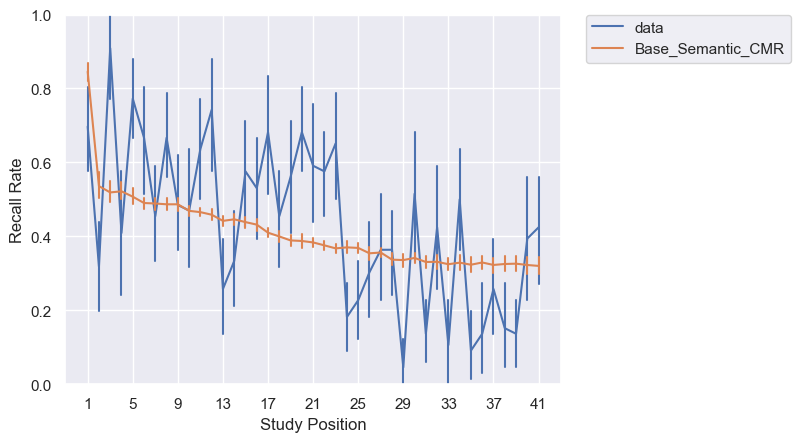

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


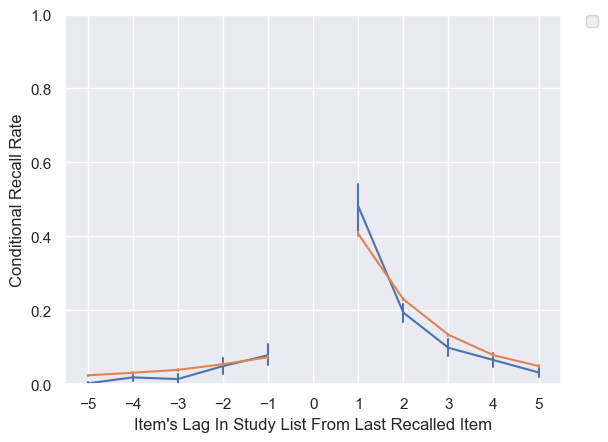

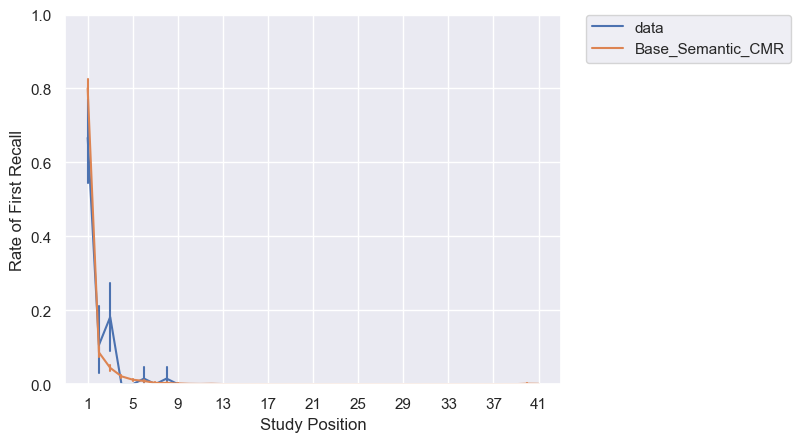

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


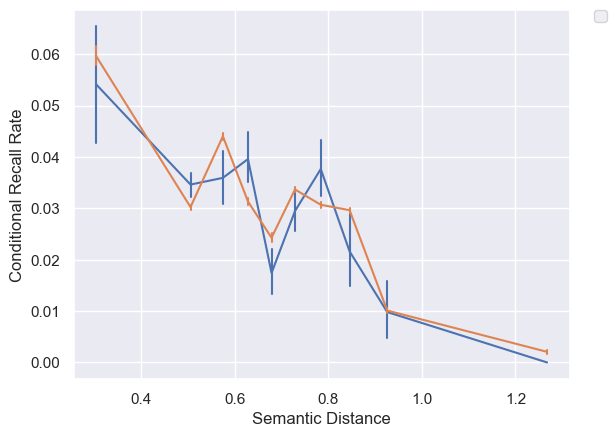

sim_df for Semantic_CMR with tag Murdock1962 and list length 41 already exists


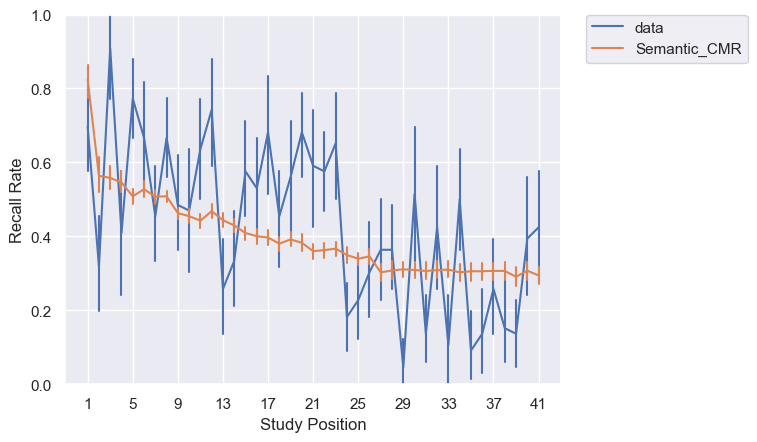

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


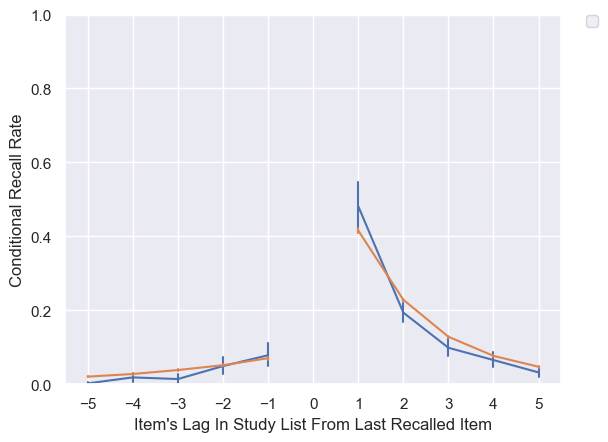

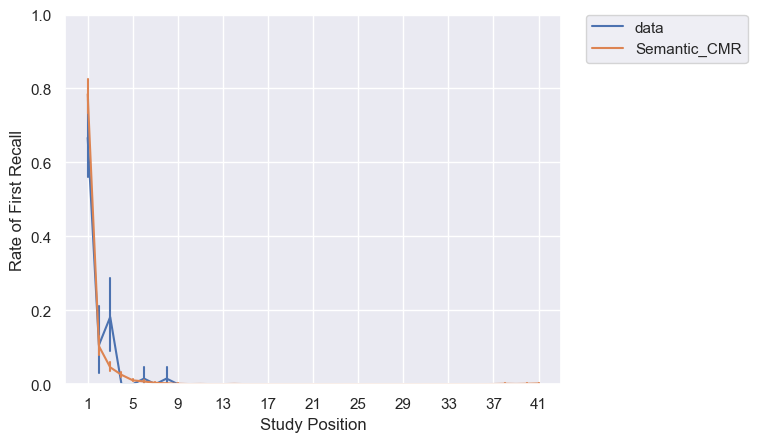

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


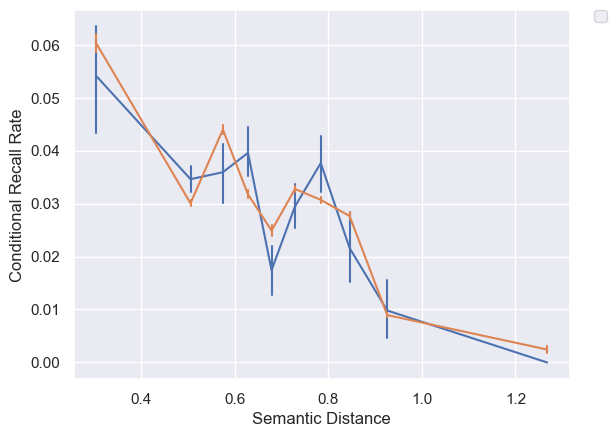

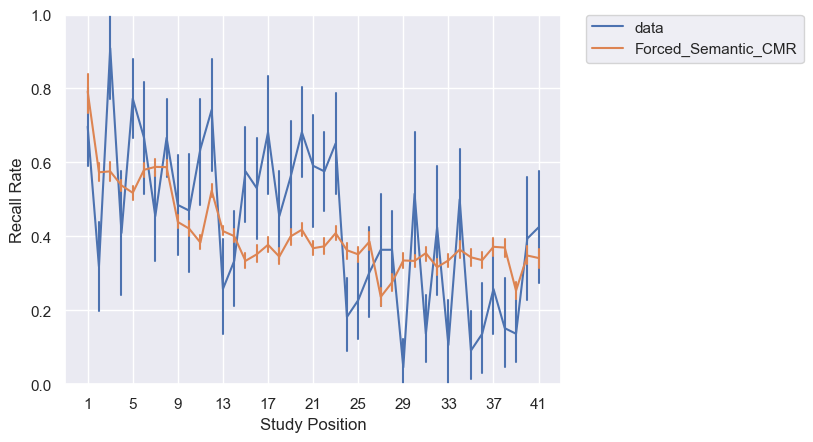

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


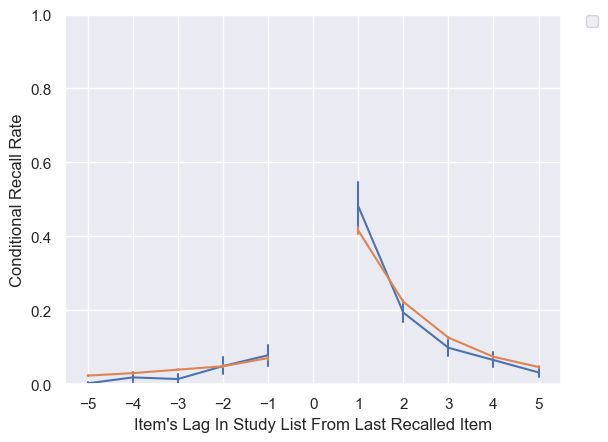

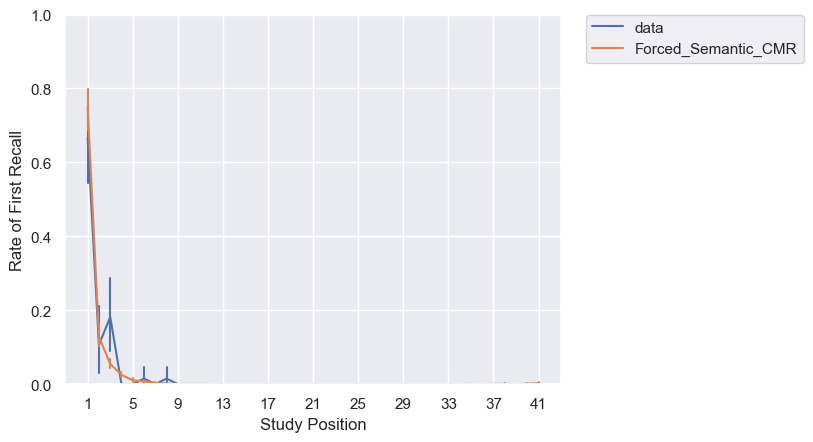

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


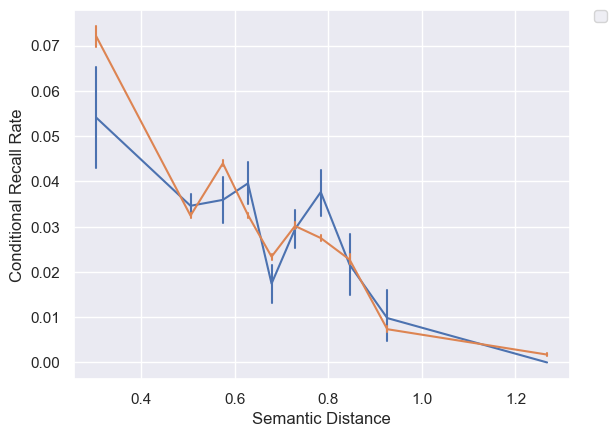

sim_df for Base_Semantic_CMR with tag Murdock1962 and list length 39 already exists


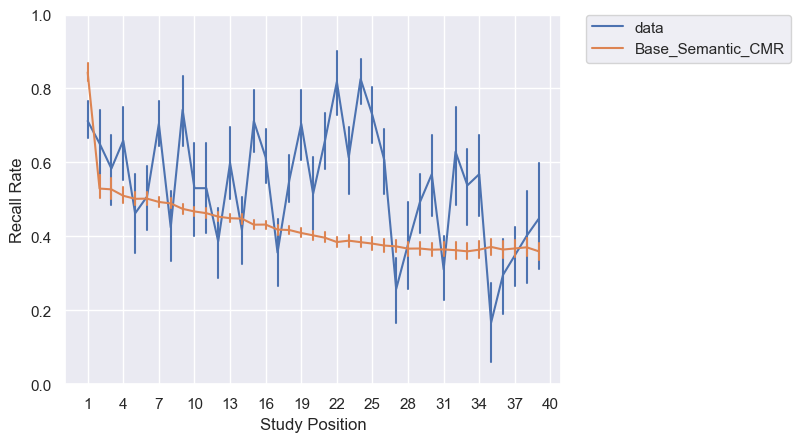

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


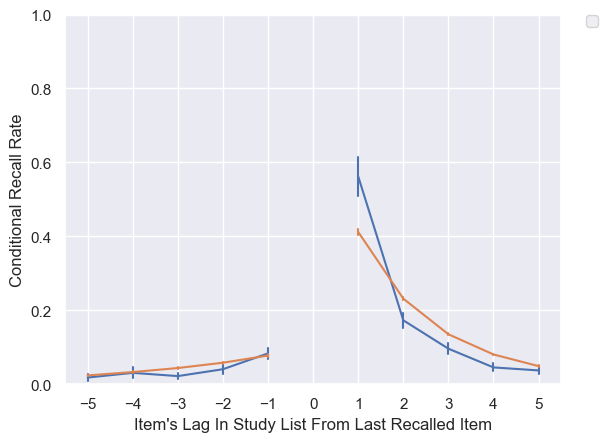

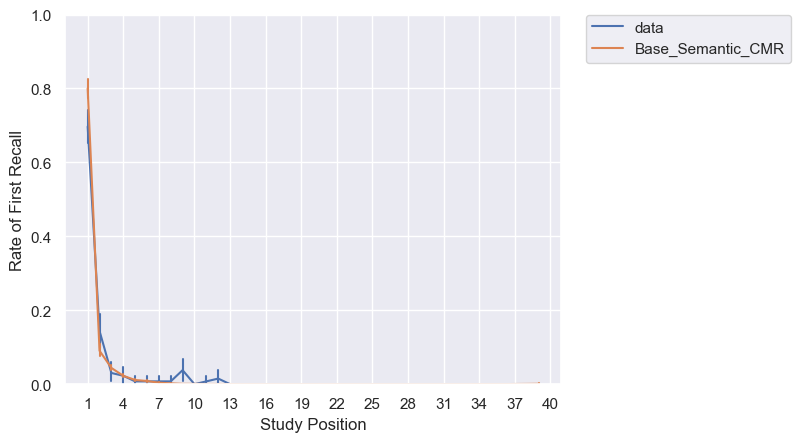

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


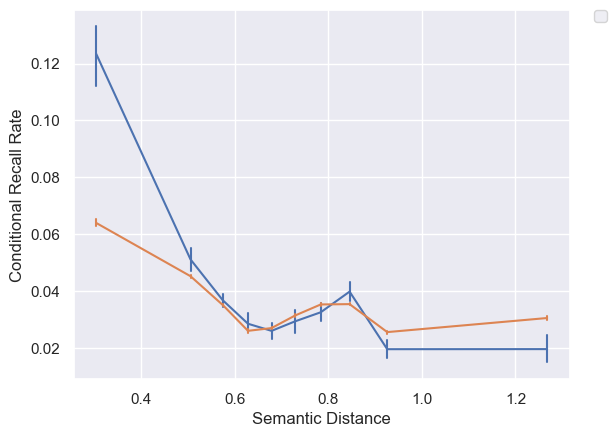

sim_df for Semantic_CMR with tag Murdock1962 and list length 39 already exists


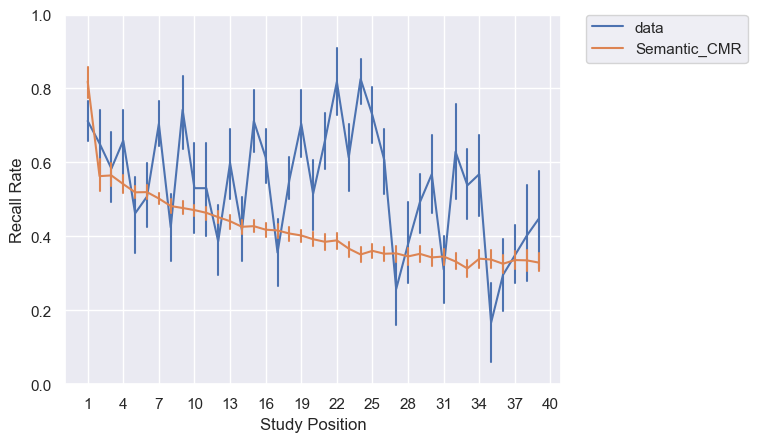

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


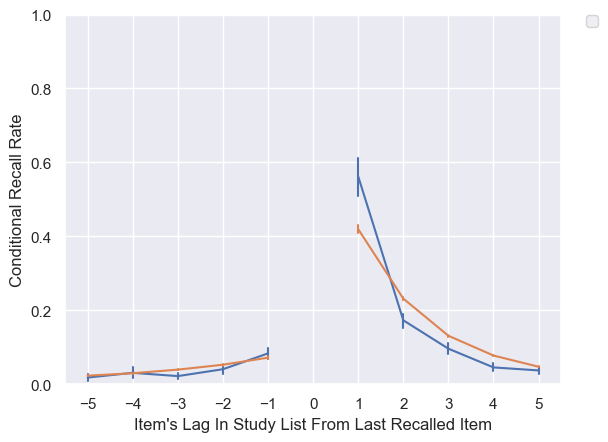

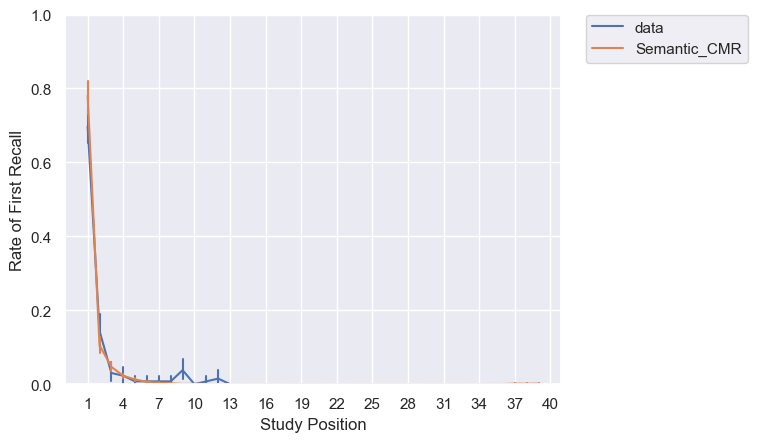

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


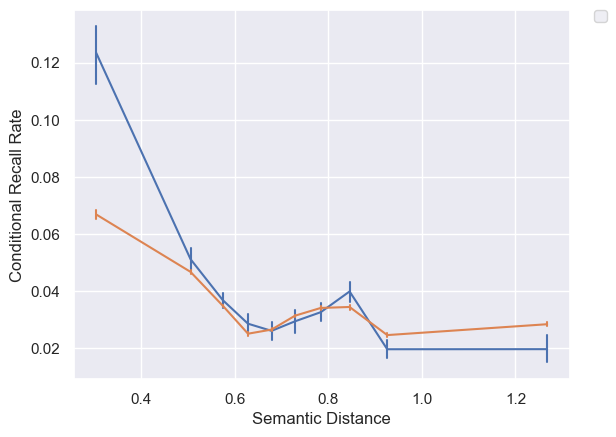

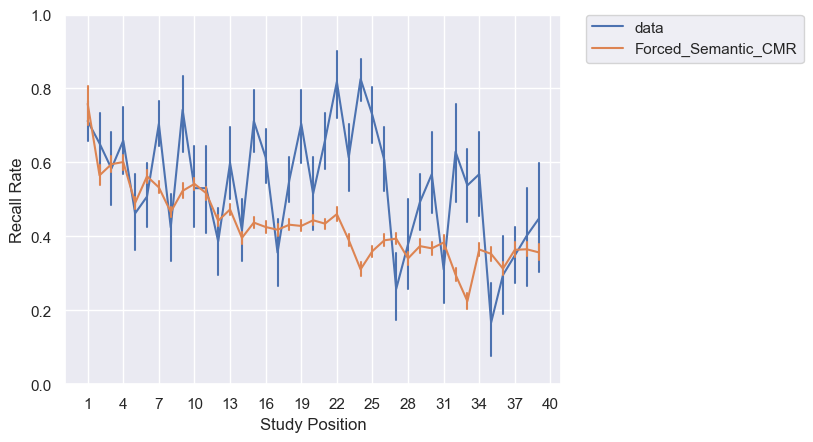

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


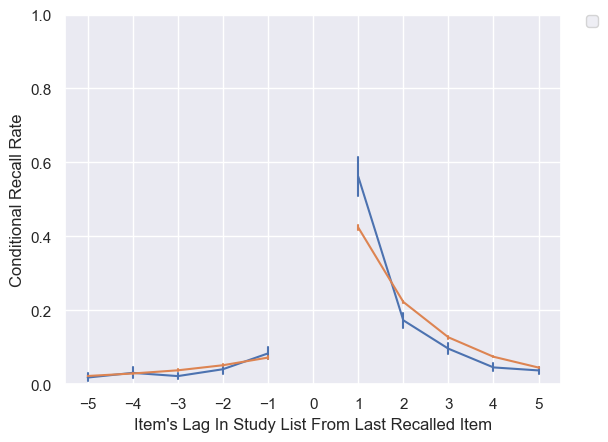

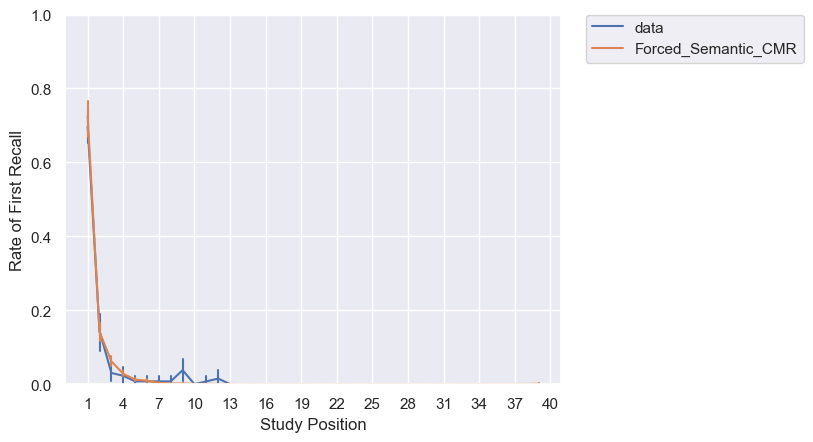

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


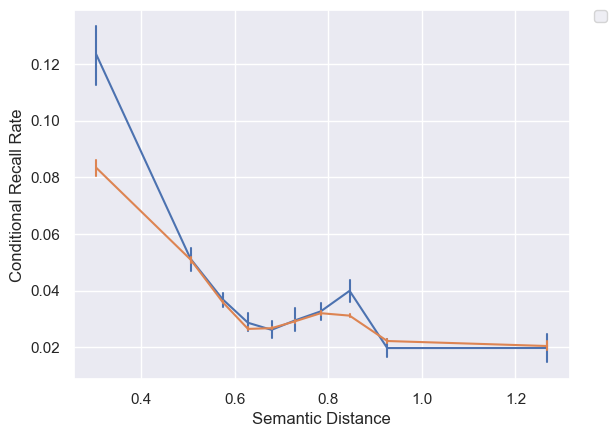

sim_df for Base_Semantic_CMR with tag Murdock1962 and list length 43 already exists


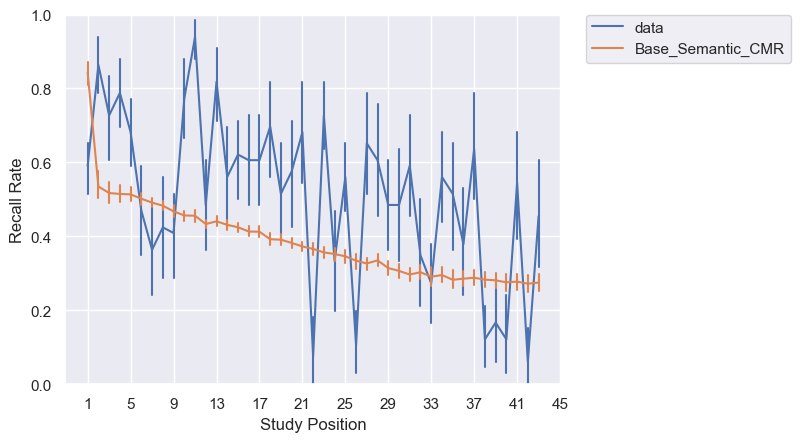

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


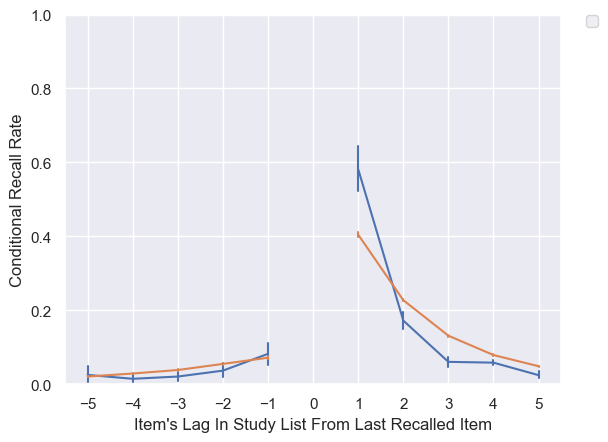

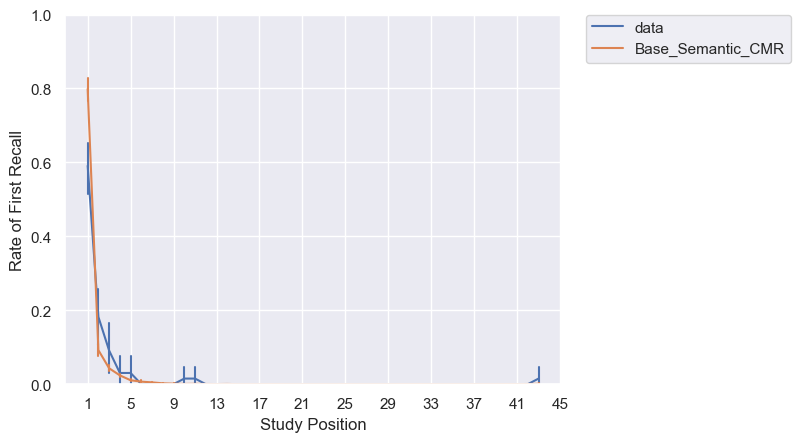

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


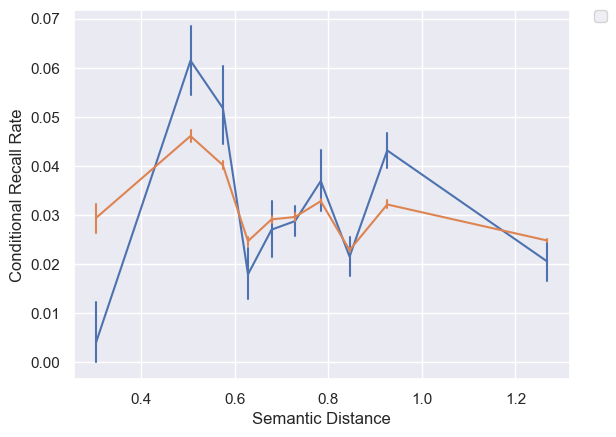

sim_df for Semantic_CMR with tag Murdock1962 and list length 43 already exists


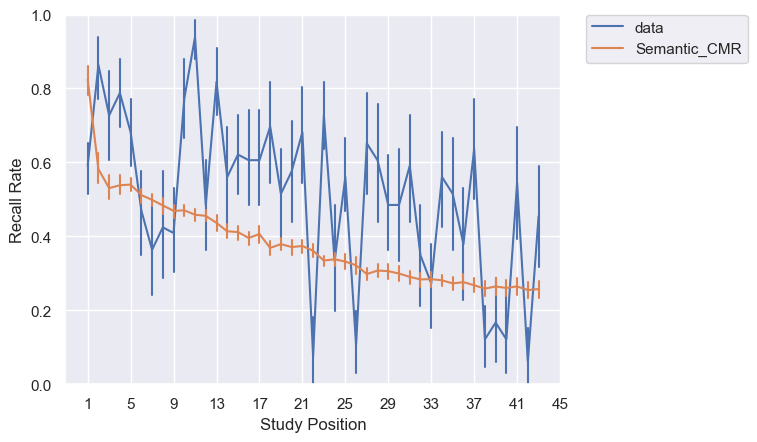

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


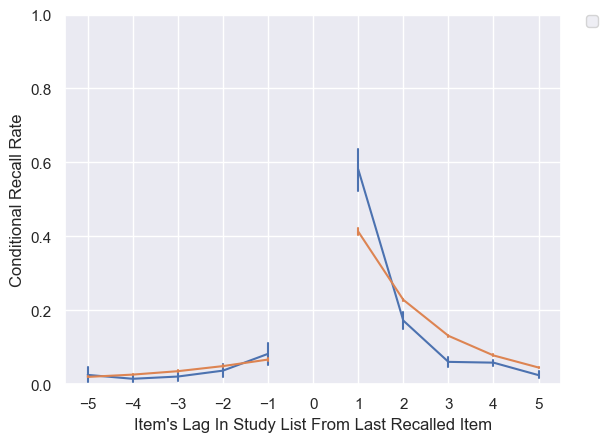

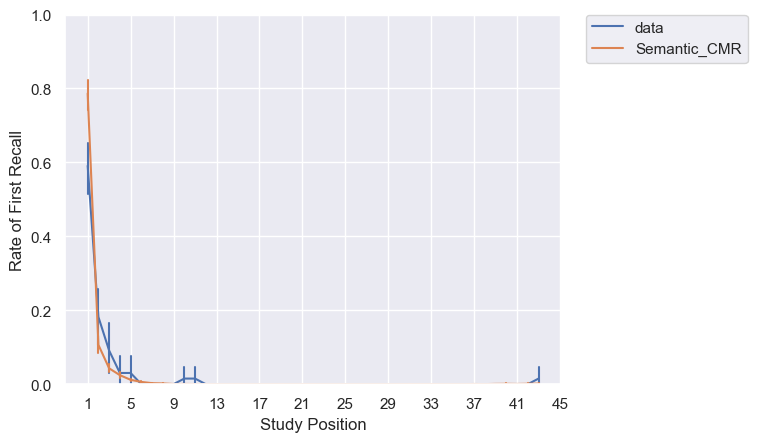

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


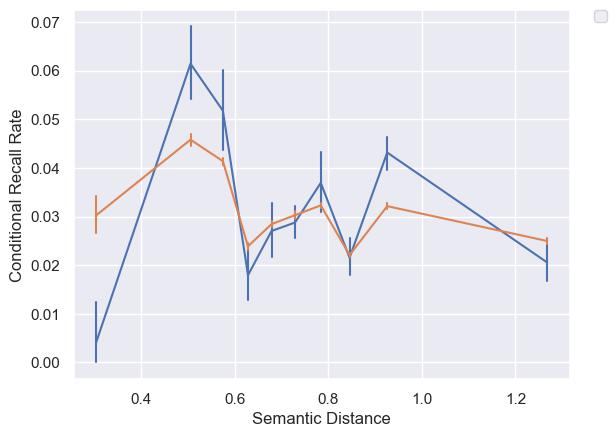

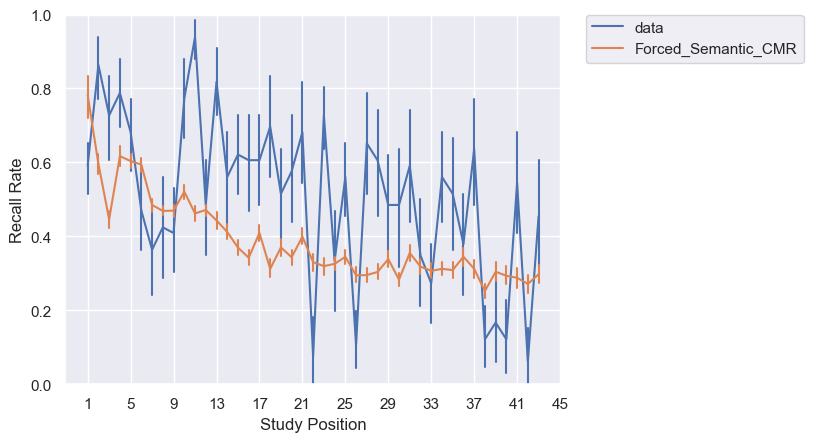

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


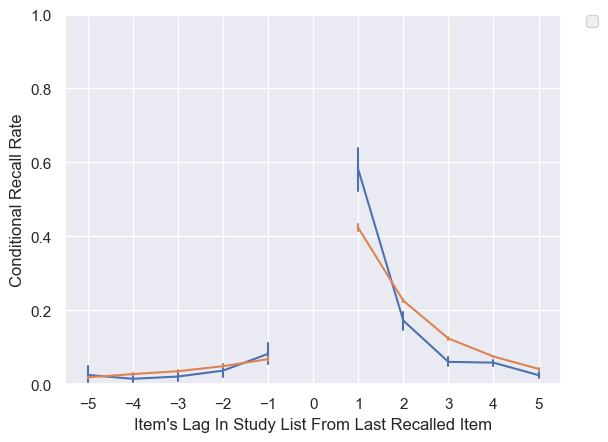

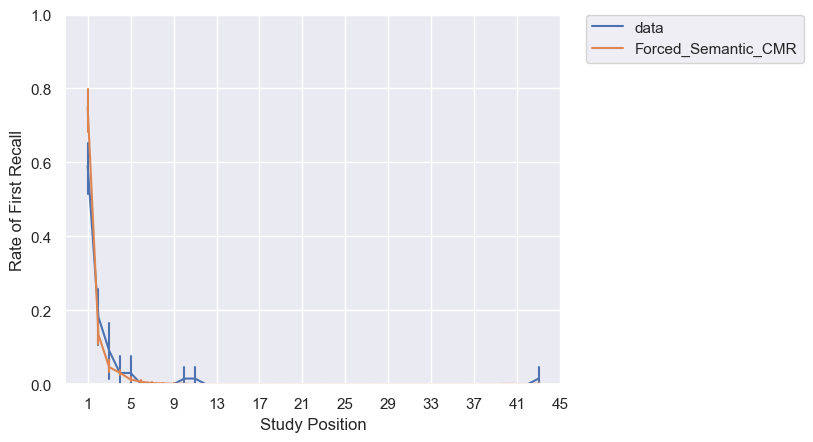

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


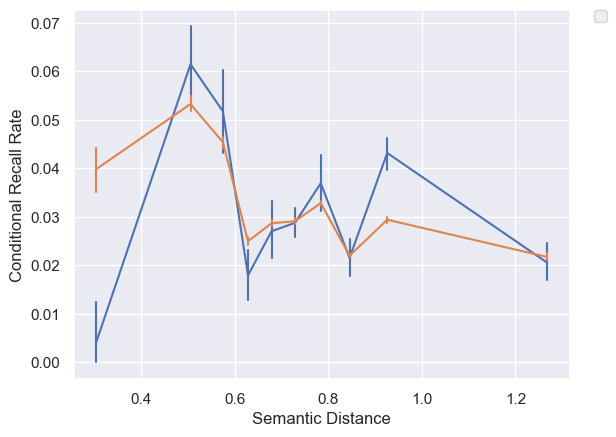

sim_df for Base_Semantic_CMR with tag Murdock1962 and list length 26 already exists


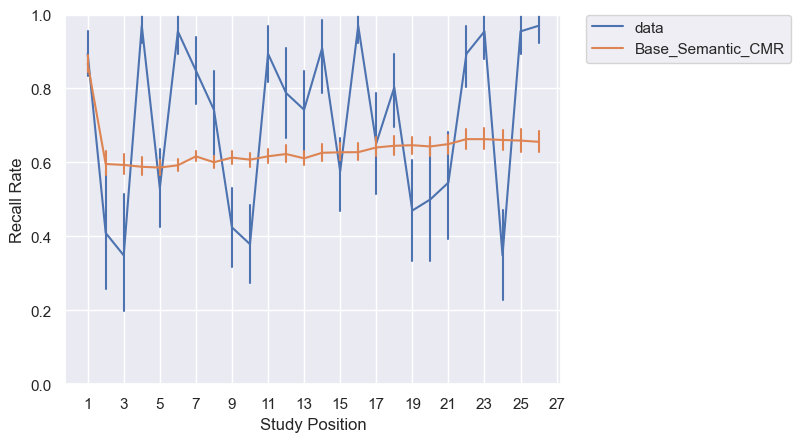

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


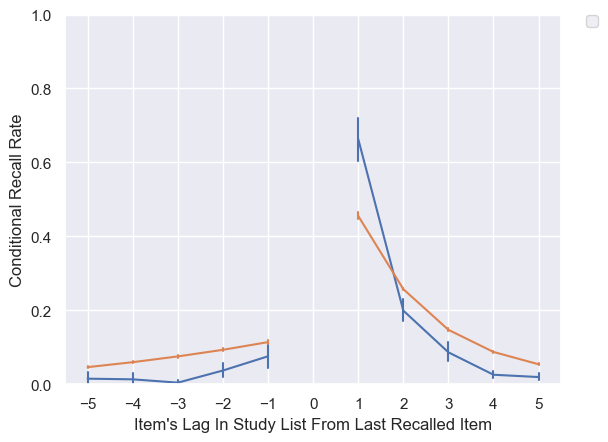

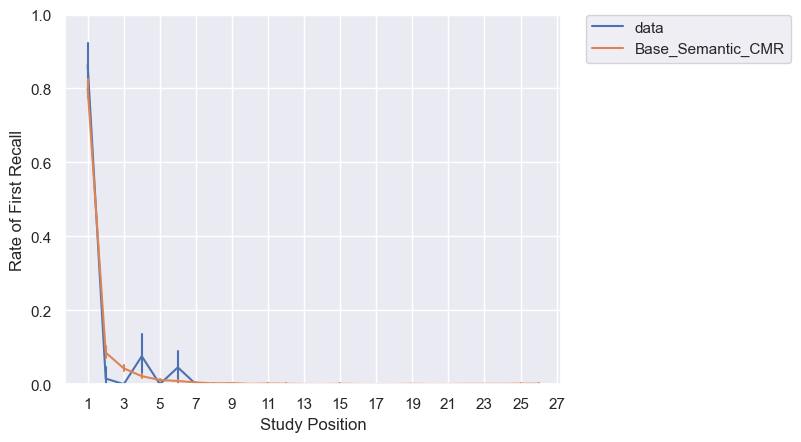

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


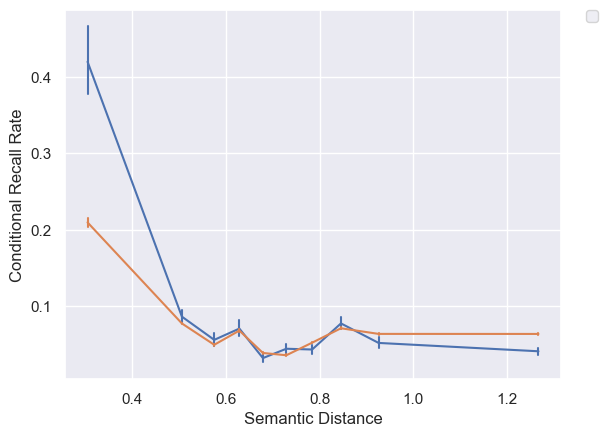

sim_df for Semantic_CMR with tag Murdock1962 and list length 26 already exists


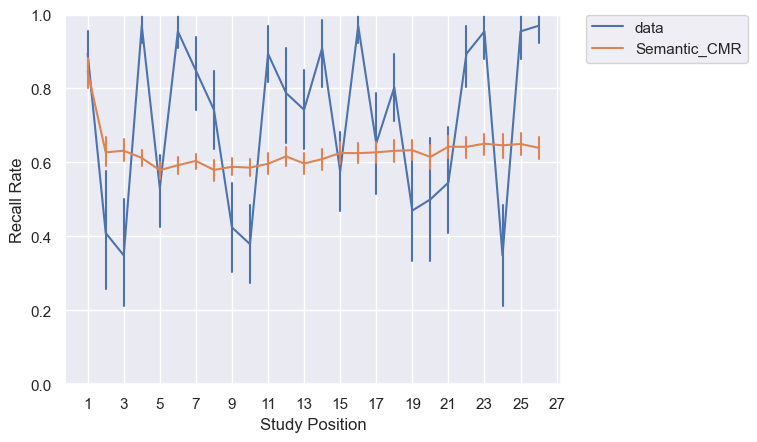

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


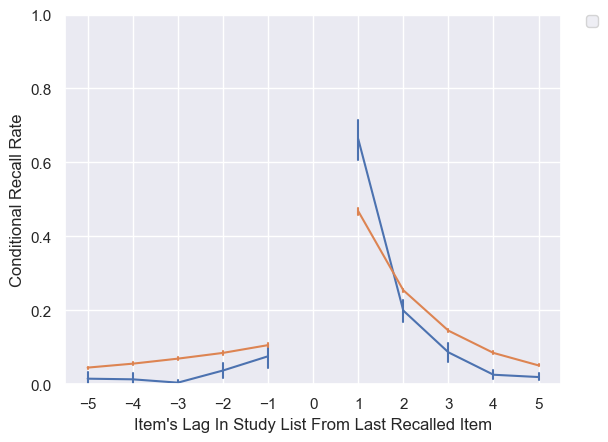

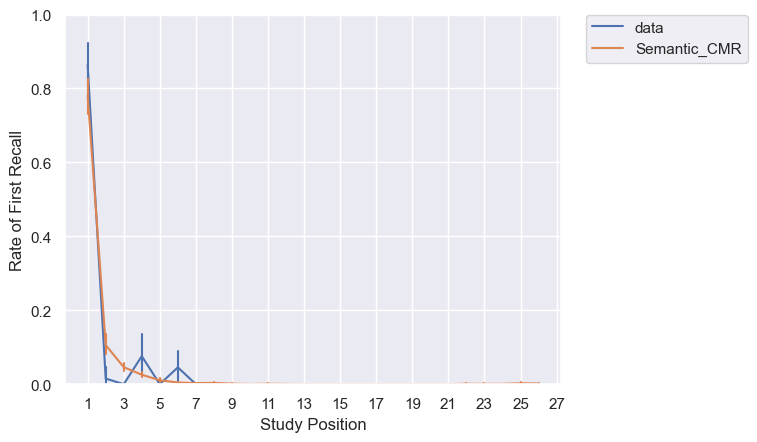

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


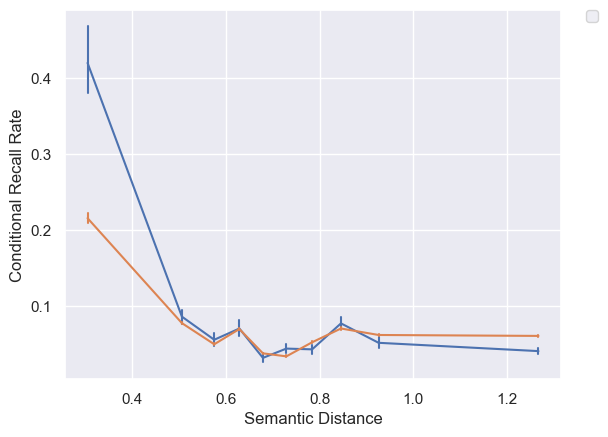

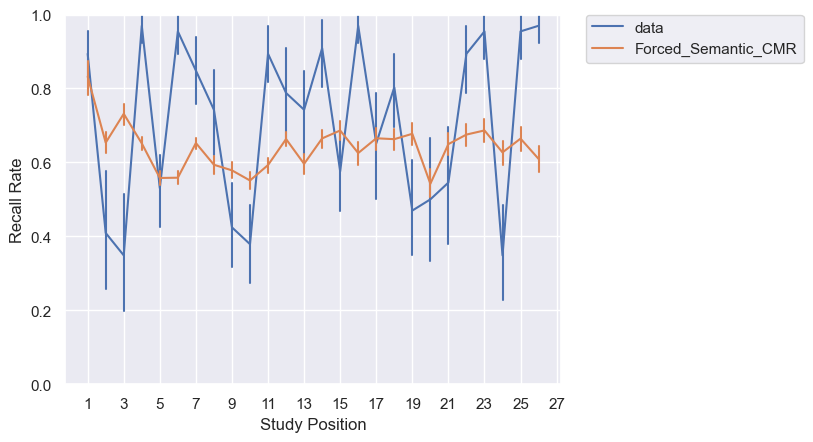

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


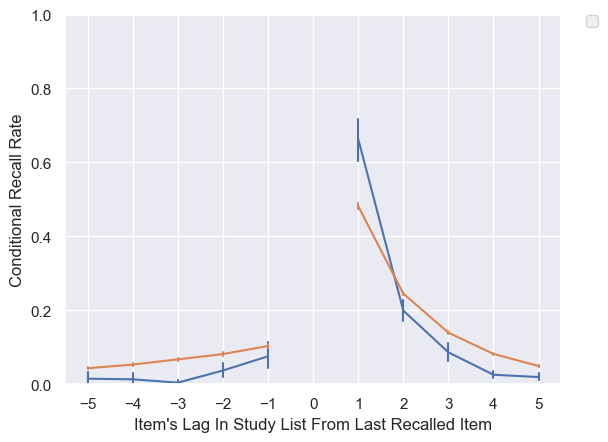

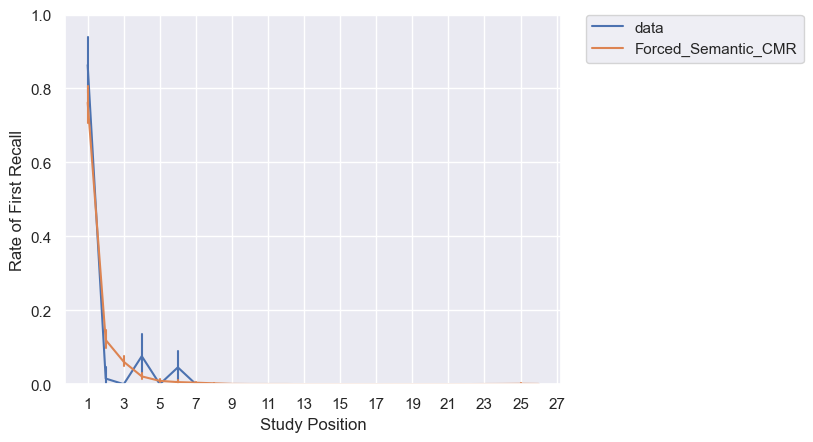

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


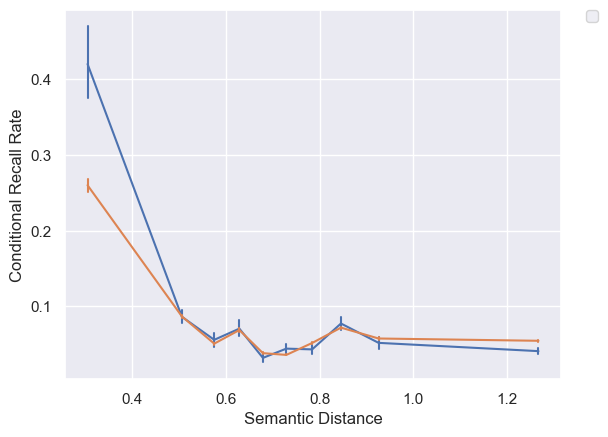

sim_df for Base_Semantic_CMR with tag Murdock1962 and list length 40 already exists


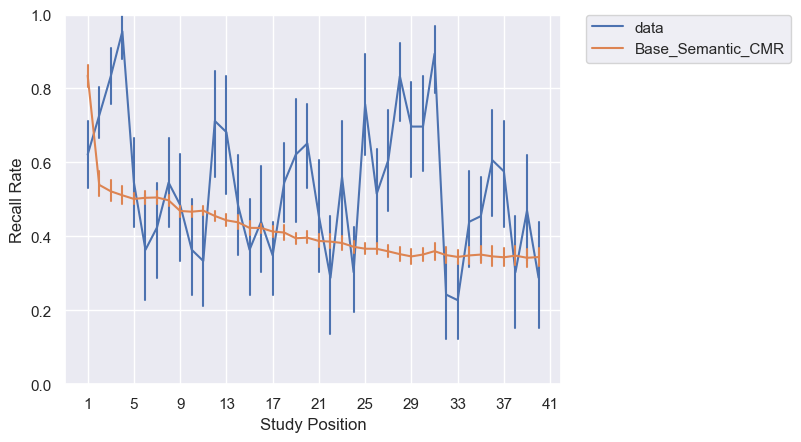

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


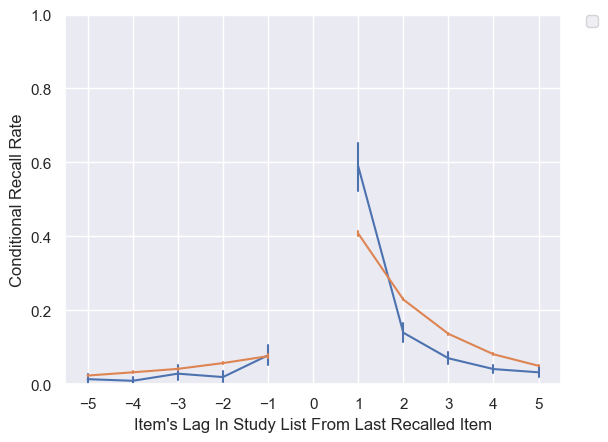

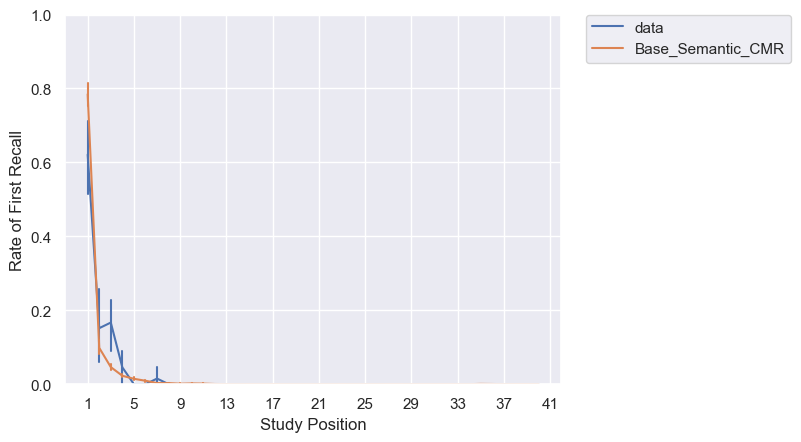

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


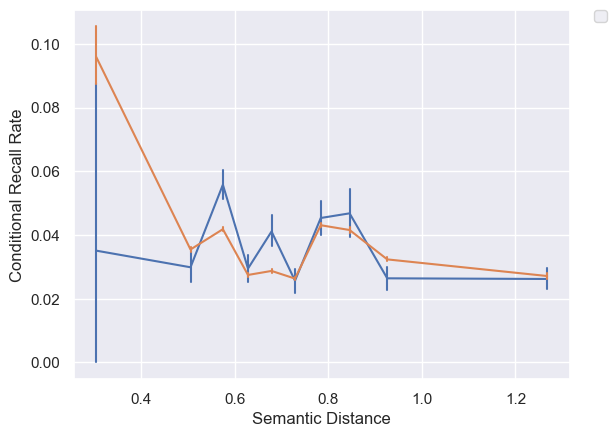

sim_df for Semantic_CMR with tag Murdock1962 and list length 40 already exists


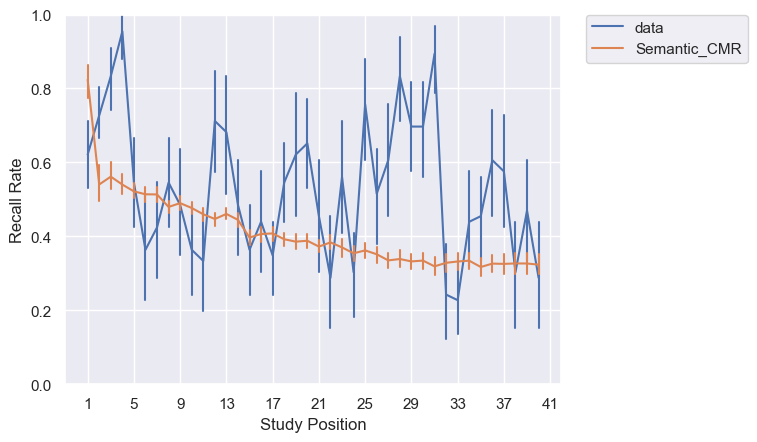

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


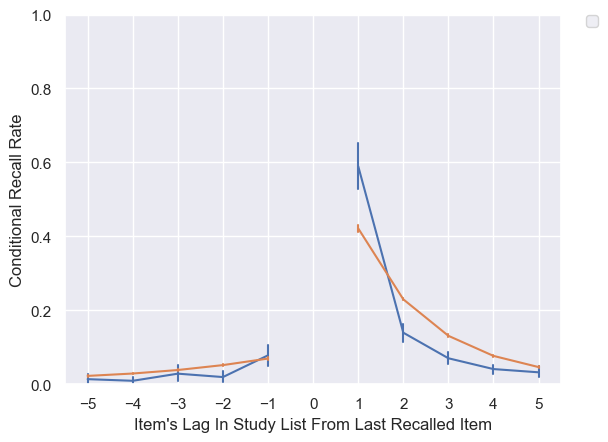

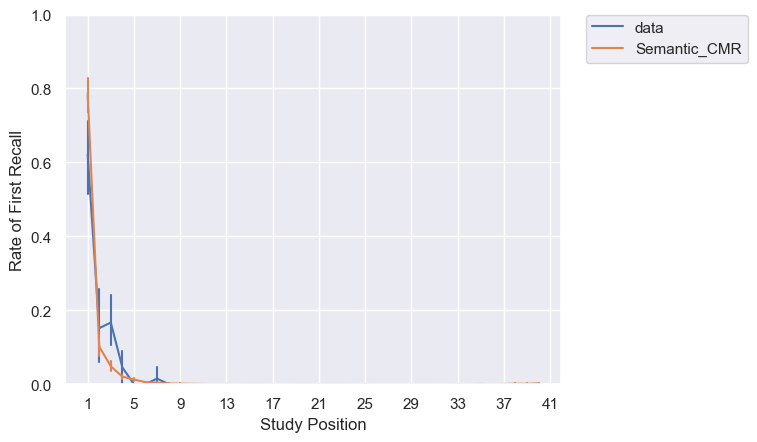

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


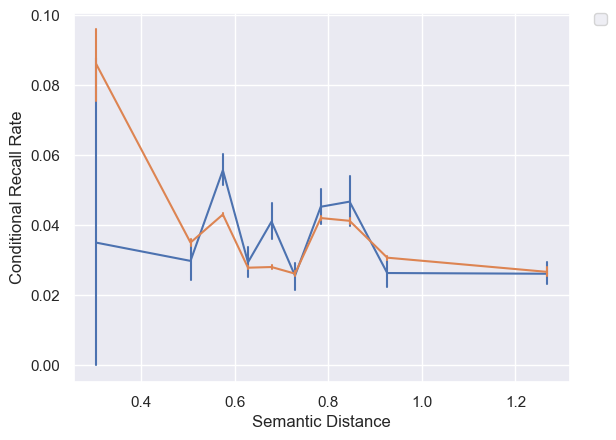

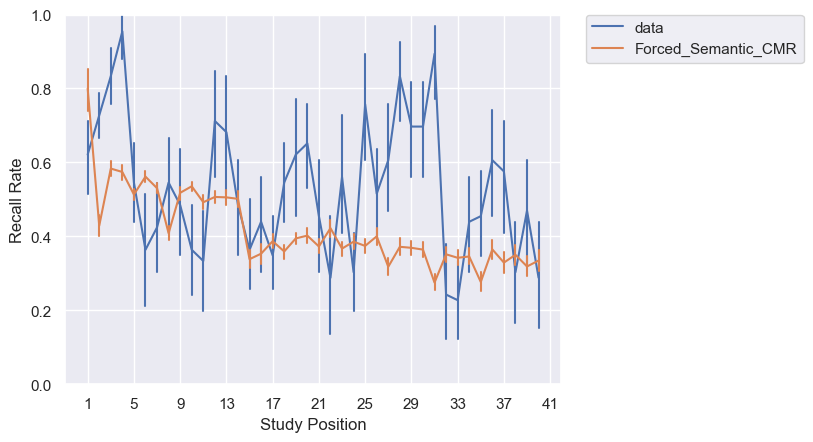

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


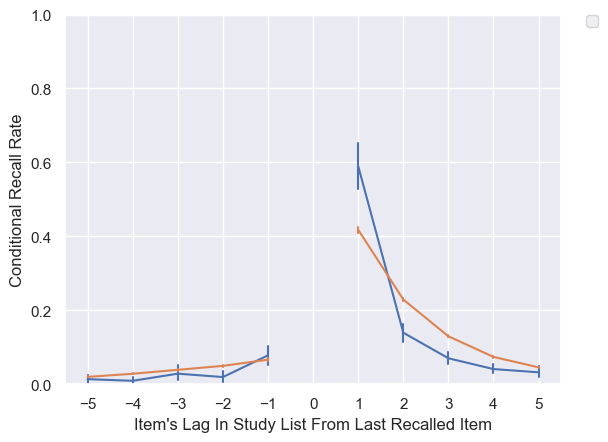

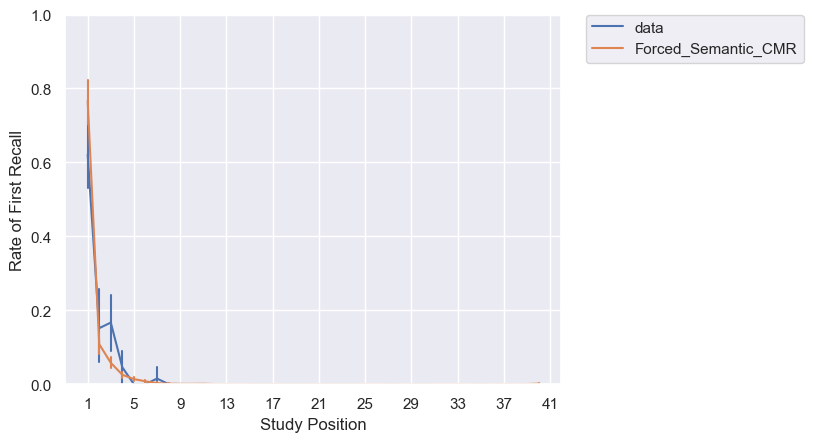

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


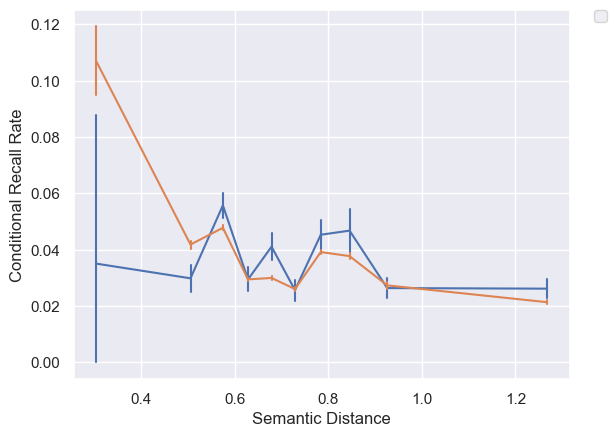

In [13]:
#| echo: false
sns.set(style='darkgrid')

# for each unique list length
if not (isinstance(list_lengths, list) or isinstance(list_lengths, List)): 
    list_lengths = [list_lengths]

for ll_index, list_length in enumerate(list_lengths):
    
    # for each unique model
    for model_index, model_class in enumerate(models):

        # load sim_df from csv if it exists
        sim_df_path = results_path + '{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length)
        if os.path.isfile(sim_df_path):
            sim_df = pd.read_csv(sim_df_path)
            print('sim_df for {} with tag {} and list length {} already exists'.format(model_names[model_index], section_tag, list_length))

        # otherwise, generate it
        else:

            @njit(fastmath=True, nogil=True)
            def init_model(item_count, presentation_count, parameters):
                return model_class(item_count, presentation_count, parameters)

            # for each unique matching entry in individual df
            sim_dfs = []
            for subject in pd.unique(individual_fits.subject):
                
                fit_result = individual_fits.query(f'subject == {subject} & model == "{model_names[model_index]}"')

                # configure model based on specified parameters
                fitted_parameters = Dict.empty(
                    key_type=types.unicode_type, value_type=types.float64
                )
                for i in range(len(free_parameters[model_index])):
                    fitted_parameters[free_parameters[model_index][i]] = fit_result[free_parameters[model_index][i]].values[0]
                for key in fixed_parameters[model_index]:
                    fitted_parameters[key] = fixed_parameters[model_index][key]

                if 'list length' in events.columns:
                    ll_specific_trial_query = trial_query + f' & subject == {subject} & `list length` == {list_length}'
                else:
                    ll_specific_trial_query = trial_query + f' & subject == {subject}'

                trial_mask = generate_trial_mask(events, ll_specific_trial_query)
                if np.sum([np.sum(trial_mask[i]) for i in range(len(trial_mask))]) == 0:
                    continue

                # simulate df based on specified trial_count and experiment_count
                sim_dfs.append(simulate_df_from_events(
                    init_model, fitted_parameters, events, ll_specific_trial_query, experiment_count, 
                    language_model=language_model, item_strings=item_strings))
                sim_dfs[-1].subject = subject
                sim_dfs[-1].list_length = list_length

            # concatenate simulations into one dataframe
            if len(sim_dfs) == 0:
                sim_df = None
                continue
            sim_df = pd.concat(sim_dfs)

            # save sim_df to csv
            sim_df.to_csv(results_path +'{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length), index=False)

        if sim_df is None:
            continue

        # design general filter for analysis df
        if len(list_lengths) > 1:
            analysis_query = trial_query + f' & `list length` == {list_length}'
        else:
            analysis_query = trial_query
            
        # generate plot for each parametrized analysis and model
        for analysis_index, analysis_function in enumerate(analyses):
            analysis_name = analysis_names[analysis_index]

            if analysis_name != 'semcrp':
                axis = analysis_function(
                    [events, sim_df], analysis_query, contrast_name="source", 
                    labels=["data", model_names[model_index]])
            else:
                axis = analysis_function(
                    [events, sim_df], analysis_query, language_model, contrast_name="source", 
                    labels=["data", model_names[model_index]])
            plt.savefig(figures_path+'{}_{}_ll{}_{}.pdf'.format(section_tag, model_names[model_index], list_length, analysis_name), bbox_inches="tight")
            plt.show()